Continuation to ps2-eventual-convergence which shows that MEEM and Capytaine have the same values for the staircase configurations that approximate slants, they just appear to disagree when the Capytaine panel counts are too low. Not much new here.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from numpy import sqrt
import time

import capytaine as cpt

import sys
import os
sys.path.append(os.path.relpath('../../'))
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem
from capytaine_generator import CapytaineSlantSolver

import pickle


In [2]:
# Setting variables for various configurations being considered.
file1 = "data/ps3.pkl"

# configurations = []

# h = 100
# a = [3, 7]
# heaving = [0, 1]
# m0 = 0.9
# rho = 1023

# for i in range(1, 20, 1):
#   d1 = 5 * i
#   config = {"name" : "config-(d1=" + str(d1) + ")",
#             "h" : h,
#             "a" : a,
#             "d_in" : [d1, d1],
#             "d_out" : [d1, 5],
#             "heaving": heaving,
#             "NMK" : [50, 50, 50],
#             "m0" : m0,
#             "rho" : rho}
#   configurations.append(config)

In [ ]:
# Helper functions for data generation
def make_slant_region(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  d_in_prime = []
  d_out_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
     d_in_prime.append(d1 + i * delta_d)
     d_out_prime.append(d1 + (1 + i) * delta_d)
  return a_prime, d_prime, d_in_prime, d_out_prime

def slant_approx_vars(a, d_in, d_out, heaving, NMK, res):
  a_prime = []
  d_prime = []
  d_in_prime = []
  d_out_prime = []
  heaving_prime = []
  NMK_prime = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        d_in_prime.append(d_in[i])
        d_out_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add, d_in_add, d_out_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
       d_in_prime += d_in_add
       d_out_prime += d_out_add
  NMK_prime.append(NMK[-1])
  return d_prime, a_prime, d_in_prime, d_out_prime, heaving_prime, NMK_prime

def solve_MEEM(h, d, a, heaving, NMK, m0, rho):
  prob = Problem(h, d, a, heaving, NMK, m0, rho)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  am, dp = prob.hydro_coeffs(x, "capytaine")
  return prob, cs, am, dp

def compute_boxes(config, res):
  newvars = slant_approx_vars(config["a"], config["d_in"], config["d_out"], config["heaving"], config["NMK"], res)
  prob, cs, am, dp = solve_MEEM(config["h"], newvars[0], newvars[1], newvars[4], newvars[5], config["m0"], config["rho"])
  t_densities = [int(10 * r) for r in newvars[1]]
  cpt_results = css.construct_and_solve(newvars[1], newvars[0], newvars[0], newvars[4], t_densities, max(150, res * 20), config["h"], config["m0"], config["rho"], 1)[0]
  amc, dpc = (cpt_results.added_mass)["Heave"], (cpt_results.radiation_damping)["Heave"]
  return am, dp, amc, dpc

css = CapytaineSlantSolver(False, False, False, False, False)

def compute_cpt_slant(config):
  t_densities = [int(10 * r) for r in config["a"]]
  respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 150, config["h"], config["m0"], config["rho"], 1)
  am, dp = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"]
  return am, dp

def compute_boxes_with_f(config, res, f_densities):
  newvars = slant_approx_vars(config["a"], config["d_in"], config["d_out"], config["heaving"], config["NMK"], res)
  # prob, cs, am, dp = solve_MEEM(config["h"], newvars[0], newvars[1], newvars[4], newvars[5], config["m0"], config["rho"])
  t_densities = [int(10 * r) for r in newvars[1]]
  cpt_results = construct_and_solve(newvars[1], newvars[0], newvars[0], newvars[4], t_densities, 150, config["h"], config["m0"], config["rho"], 1, f_densities)[0]
  amc, dpc = (cpt_results.added_mass)["Heave"], (cpt_results.radiation_damping)["Heave"]
  return amc, dpc, # amc, dpc

In [ ]:
# Data generation (now commented out)
# for config in configurations:
  # meem_box_am1, meem_box_dp1, cpt_box_am1, cpt_box_dp1 = compute_boxes(config, 1)
  # config["MEEM box AM"] = meem_box_am1
  # config["MEEM box DP"] = meem_box_dp1
  # config["CPT box AM"] = cpt_box_am1
  # config["CPT box DP"] = cpt_box_dp1
  # config["MEEM approx AMs"] = [meem_box_am1]
  # config["MEEM approx DPs"] = [meem_box_dp1]
  # config["CPT approx AMs"] = [cpt_box_am1]
  # config["CPT approx DPs"] = [cpt_box_dp1]
  # update_data_file(configurations, "data/pseudo-slant-3.pkl")
  # for res in range(1, 24):
  #   meem_box_am, meem_box_dp, cpt_box_am, cpt_box_dp = compute_boxes(config, res)
  #   config["MEEM approx AMs"].append(meem_box_am)
  #   config["MEEM approx DPs"].append(meem_box_dp)
  #   config["CPT approx AMs"].append(cpt_box_am)
  #   config["CPT approx DPs"].append(cpt_box_dp)
  #   update_data_file(configurations, "data/pseudo-slant-3.pkl")
  # cpt_slant_am, cpt_slant_dp = compute_cpt_slant(config)
  # config["CPT slant AM"] = cpt_slant_am
  # config["CPT slant DP"] = cpt_slant_dp
  # update_data_file(configurations, "data/pseudo-slant-3.pkl")
  # print("Finished a configuration. " + config["name"])

  # took ~ 2+ days to run

In [11]:
# Plotting functions
def plot_comparison_wrt_depth(configurations, coefficient, res_lst, modifunc = None):
  # coefficient = "AM" or "DP"
  x = [i * 0.01 for i in list(range(5, 100, 5))]

  meem_box_values = [config["MEEM box " + coefficient] for config in configurations]
  cpt_box_values = [config["CPT box " + coefficient] for config in configurations]
  cpt_slant_values = [config["CPT slant " + coefficient] for config in configurations]

  meem_res_high = [config["MEEM approx " + coefficient + "s"][res_lst[-1] - 1] for config in configurations]
  box_ratios = [a / b for a, b in zip(meem_box_values, cpt_box_values)]
  high_res_to_slant_ratios = [a / b for a, b in zip(meem_res_high, cpt_slant_values)]


  cmap = get_cmap('Blues')
  interval = 0.7/len(res_lst)
  colors = [cmap(0.95 - interval * i) for i in range(len(res_lst))]

  i = 0
  for res in res_lst:
    if res == res_lst[-1] or res == res_lst[0]: label = "res = " + str(res) + ", MEEM/CPT"
    else: label = None
    meem_res = [config["MEEM approx " + coefficient + "s"][res - 1] for config in configurations]
    cpt_res = [config["CPT approx " + coefficient + "s"][res - 1] for config in configurations]
    ratio = [a / b for a, b in zip(meem_res, cpt_res)]
    plt.plot(x, ratio, color = colors[i], label = label)
    i += 1

  plt.plot(x, high_res_to_slant_ratios, label='high res MEEM / CPT slant', color = "red", linestyle = "-")

  if modifunc is not None:
    modded_high_res_MEEM = [modifunc(config, max_res - 1, coefficient) for config in configurations]
    mod_to_slant_ratios = [a / b for a, b in zip(modded_high_res_MEEM, cpt_slant_values)]
    plt.plot(x, mod_to_slant_ratios, label='mod to slant', color = "orange", linestyle = "-")

  # Labels and title
  plt.xlabel('d1/h')
  plt.ylabel("MEEM to Capytaine " + coefficient + " ratio")
  plt.title(coefficient + " for varying depth")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()

def plot_comparison(meem_box, cpt_box, cpt_slant, meem_approx, cpt_approx, coeff_name, config_name):
  x = list(range(1, 24))

  margin1 = 0.05
  margin2 = 0.10

  # box_ratio = meem_box/cpt_box

  plt.axhline(y = meem_box, color='blue', linestyle='-', label = "box ratio")
  plt.axhline(y = cpt_box, color='black', linestyle='-', label = "CPT box")
  plt.axhline(y = cpt_slant, color='green', linestyle='-', label = "CPT slant")
  plt.axhline(y = cpt_slant * (1 + margin1), color='green', linestyle='--')
  plt.axhline(y = cpt_slant * (1 - margin1), color='green', linestyle='--')
  plt.axhline(y = cpt_slant * (1 + margin2), color='green', linestyle=':')
  plt.axhline(y = cpt_slant * (1 - margin2), color='green', linestyle=':')

  plt.plot(x, meem_approx, label='MEEM approx', color = "blue", linestyle = "--")
  plt.plot(x, cpt_approx, label='CPT approx', color = "black", linestyle = "--")

  # Labels and title
  plt.xlabel('Slant resolution')
  plt.ylabel(coeff_name)
  plt.title(coeff_name + " ratio for configuration " + config_name)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()

def plot_slant_convergences(config):
  plot_comparison(config["MEEM box AM"], config["CPT box AM"], config["CPT slant AM"],
                  config["MEEM approx AMs"][0:23], config["CPT approx AMs"][0:23], "Added mass", config["name"])
  # plot_comparison(data_dict["MEEM box DP"], data_dict["CPT box DP"], data_dict["CPT slant DP"],
  #                 data_dict["MEEM approx DPs"], data_dict["CPT approx DPs"], "Damping", name)

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_58859/452459612.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues')


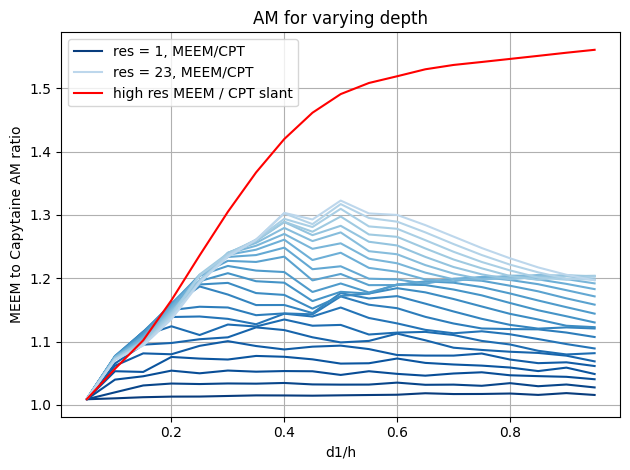

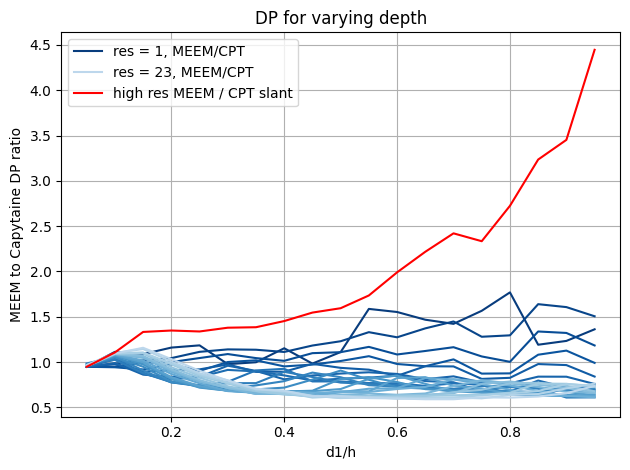

In [13]:
with open(file1, "rb") as f:
  configurations = pickle.load(f)

plot_comparison_wrt_depth(configurations, "AM", list(range(1, 24)))
plot_comparison_wrt_depth(configurations, "DP", list(range(1, 24)))

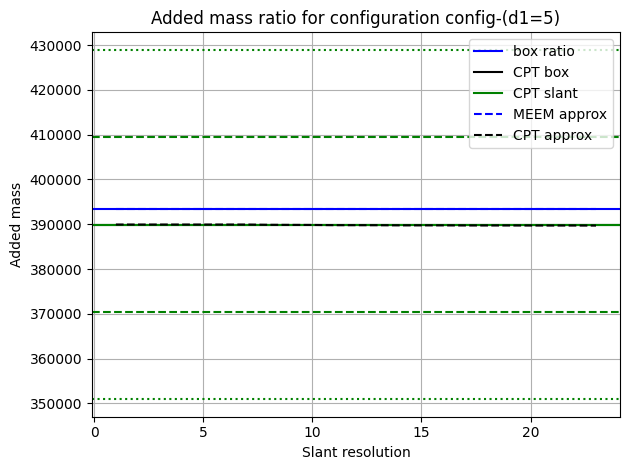

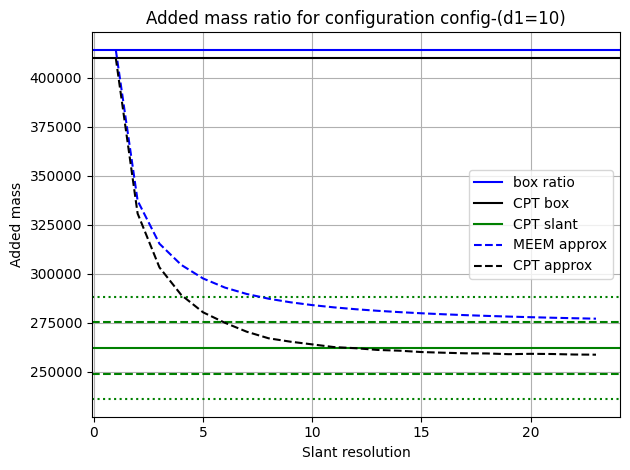

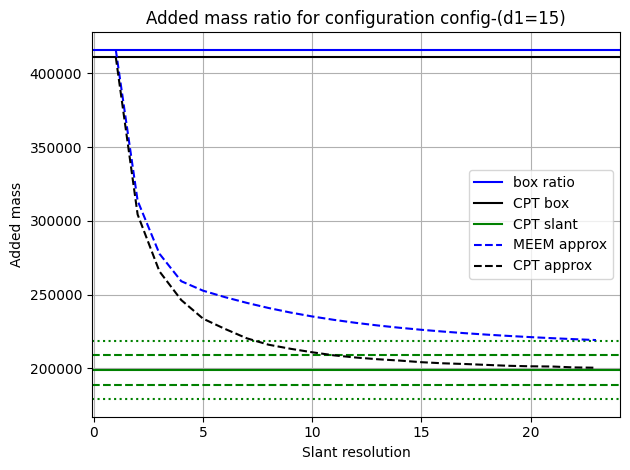

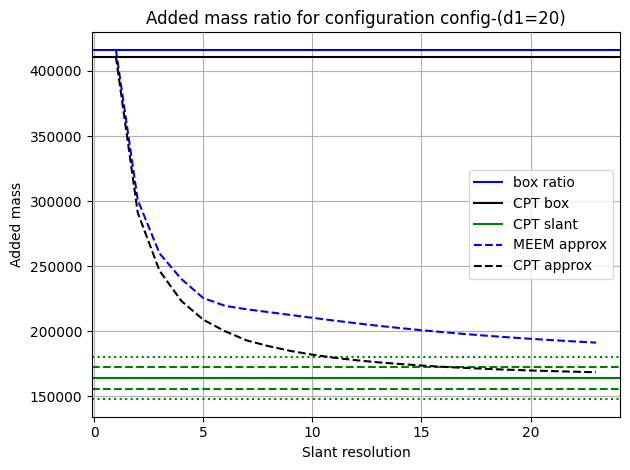

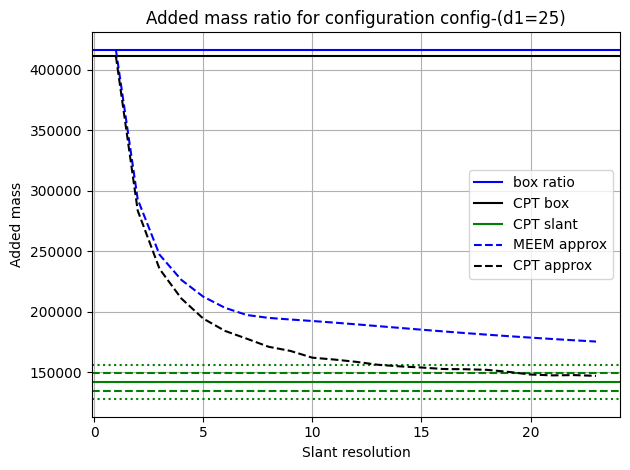

In [ ]:
for config in configurations[0:5]:
  plot_slant_convergences(config)

In [ ]:
# for config in configurations[13:]:
#   config["CPT Splice AMs"] = []
#   config["CPT Splice DPs"] = []

#   for res in range(2, 21):
#     delta_d = (config["d_in"][0] - config["d_in"][1])/res
#     vert_dense = max(10, int(delta_d))
#     f_dense = [10, vert_dense] * (res + 1)
#     samples = compute_boxes_with_f(config, res, f_dense)
#     config["CPT Splice AMs"].append(samples[0])
#     config["CPT Splice DPs"].append(samples[1])
#     update_data_file(configurations, "data/pseudo-slant-3.pkl")
#   backup_file("data/pseudo-slant-3.pkl", "data/pseudo-backup-"+config["name"]+".pkl")

  # has completed d1 = 65
  
# This computed better mesh resolution/distribution/accuracy in the capytaine data.
# This resuted in better matching MEEM for lower d1/h (see below)

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_58859/405024288.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues')
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_58859/405024288.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Oranges')


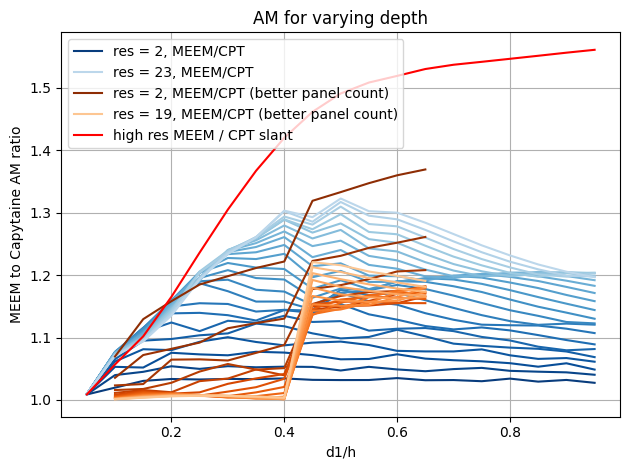

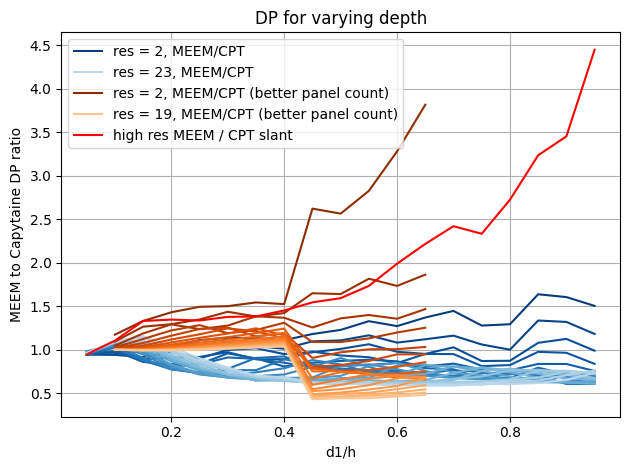

In [18]:
def plot_comparison_wrt_depth_splice(configurations, coefficient, res_lst, res_lst_2):
  # coefficient = "AM" or "DP"
  x = [i * 0.01 for i in list(range(5, 100, 5))]
  splicecap = 13
  x2 = [i * 0.01 for i in list(range(10, splicecap * 5 + 1, 5))]

  meem_box_values = [config["MEEM box " + coefficient] for config in configurations]
  cpt_box_values = [config["CPT box " + coefficient] for config in configurations]
  cpt_slant_values = [config["CPT slant " + coefficient] for config in configurations]

  meem_res_high = [config["MEEM approx " + coefficient + "s"][res_lst[-1] - 1] for config in configurations]
  box_ratios = [a / b for a, b in zip(meem_box_values, cpt_box_values)]
  high_res_to_slant_ratios = [a / b for a, b in zip(meem_res_high, cpt_slant_values)]

  cmap = get_cmap('Blues')
  interval = 0.7/len(res_lst)
  colors = [cmap(0.95 - interval * i) for i in range(len(res_lst))]
  i = 0
  for res in res_lst:
    if res == res_lst[-1] or res == res_lst[0]: label = "res = " + str(res) + ", MEEM/CPT"
    else: label = None
    meem_res = [config["MEEM approx " + coefficient + "s"][res - 1] for config in configurations]
    cpt_res = [config["CPT approx " + coefficient + "s"][res - 1] for config in configurations]
    ratio = [a / b for a, b in zip(meem_res, cpt_res)]
    plt.plot(x, ratio, color = colors[i], label = label)
    i += 1

  cmap = get_cmap('Oranges')
  interval = 0.7/len(res_lst_2)
  colors = [cmap(0.95 - interval * i) for i in range(len(res_lst_2))]
  i = 0
  for res in res_lst_2:
    if res == res_lst_2[-1] or res == res_lst_2[0]: label = "res = " + str(res) + ", MEEM/CPT (better panel count)"
    else: label = None
    meem_res = [config["MEEM approx " + coefficient + "s"][res - 1] for config in configurations[1:splicecap]]
    cpt_res = [config["CPT Splice " + coefficient + "s"][res - 1] for config in configurations[1:splicecap]]
    ratio = [a / b for a, b in zip(meem_res, cpt_res)]
    plt.plot(x2, ratio, color = colors[i], label = label)
    i += 1

  plt.plot(x, high_res_to_slant_ratios, label='high res MEEM / CPT slant', color = "red", linestyle = "-")

  # Labels and title
  plt.xlabel('d1/h')
  plt.ylabel("MEEM to Capytaine " + coefficient + " ratio")
  plt.title(coefficient + " for varying depth")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()


plot_comparison_wrt_depth_splice(configurations, "AM", list(range(2, 24)), list(range(2, 20)))
plot_comparison_wrt_depth_splice(configurations, "DP", list(range(2, 24)), list(range(2, 20)))

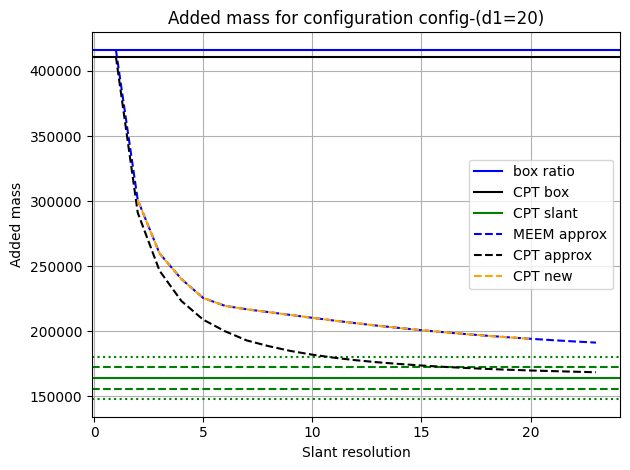

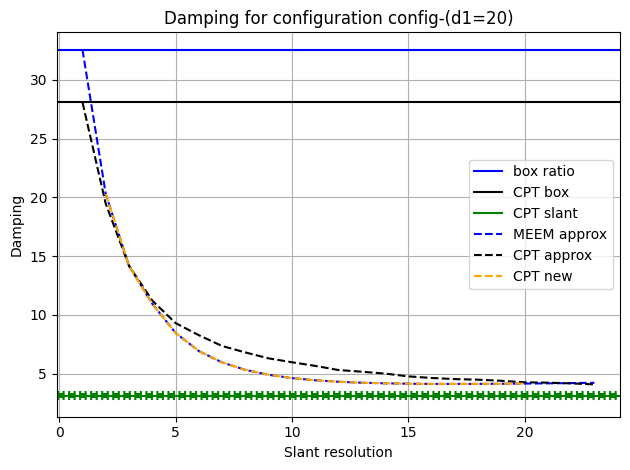

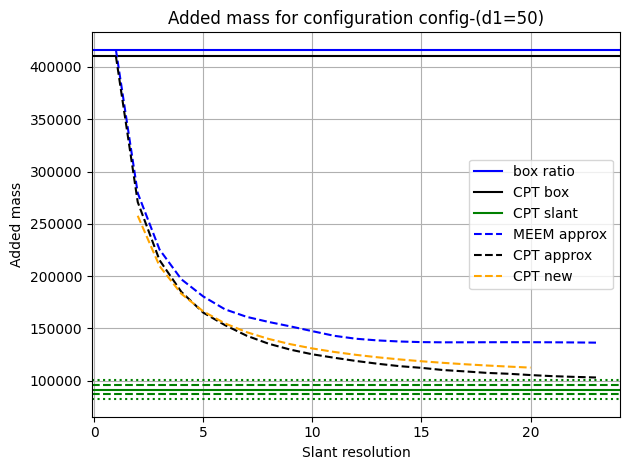

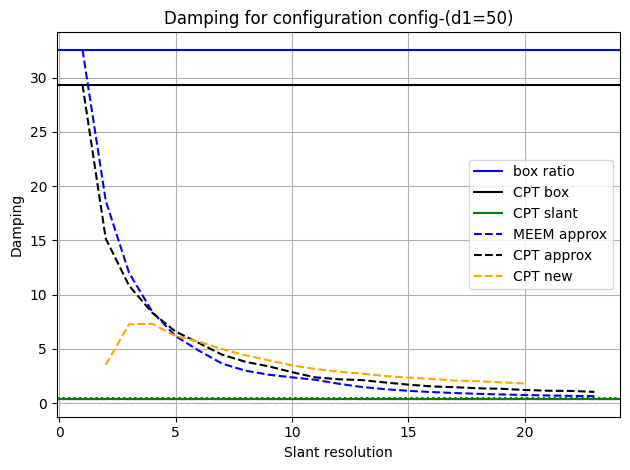

In [19]:
def plot_comparison(meem_box, cpt_box, cpt_slant, meem_approx, cpt_approx, cpt_splice, coeff_name, config_name):
  x = list(range(1, 24))
  x2 = list(range(2, 21))

  margin1 = 0.05
  margin2 = 0.10

  # box_ratio = meem_box/cpt_box

  plt.axhline(y = meem_box, color='blue', linestyle='-', label = "box ratio")
  plt.axhline(y = cpt_box, color='black', linestyle='-', label = "CPT box")
  plt.axhline(y = cpt_slant, color='green', linestyle='-', label = "CPT slant")
  plt.axhline(y = cpt_slant * (1 + margin1), color='green', linestyle='--')
  plt.axhline(y = cpt_slant * (1 - margin1), color='green', linestyle='--')
  plt.axhline(y = cpt_slant * (1 + margin2), color='green', linestyle=':')
  plt.axhline(y = cpt_slant * (1 - margin2), color='green', linestyle=':')

  plt.plot(x, meem_approx, label='MEEM approx', color = "blue", linestyle = "--")
  plt.plot(x, cpt_approx, label='CPT approx', color = "black", linestyle = "--")
  plt.plot(x2, cpt_splice, label='CPT new', color = "orange", linestyle = "--")

  # Labels and title
  plt.xlabel('Slant resolution')
  plt.ylabel(coeff_name)
  plt.title(coeff_name + " for configuration " + config_name)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()


def plot_slant_convergences(config):
  plot_comparison(config["MEEM box AM"], config["CPT box AM"], config["CPT slant AM"], config["MEEM approx AMs"][0:23],
                  config["CPT approx AMs"][0:23], config["CPT Splice AMs"][0:19], "Added mass", config["name"])
  plot_comparison(config["MEEM box DP"], config["CPT box DP"], config["CPT slant DP"], config["MEEM approx DPs"][0:23], 
                  config["CPT approx DPs"][0:23], config["CPT Splice DPs"][0:19], "Damping", config["name"])
  
for config in [configurations[3], configurations[9]]:
  plot_slant_convergences(config)